In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

movies = pd.read_csv('/content/데이터완성본.csv')

# 필요한 컬럼 가져오기
movieOst = movies[['movie_name','ost_name', '장르', '감독', 'valence', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo']]
movieOst.reset_index(drop=True, inplace=True)

# 장르 가나다순 정렬
for num_gern in range(len(movieOst['장르'])):
  sp_list = movieOst['장르'][num_gern].split(',')
  ge_list = []
  for sp_num in range(len(sp_list)):
    non_st = sp_list[sp_num].strip()
    ge_list.append(non_st)
    ge_list.sort()
  ge_list = ', '.join(s for s in ge_list)
  movieOst['장르'][num_gern] = ge_list

# 장르, 감독 라벨링
label_encoder = preprocessing.LabelEncoder()
genre_label = label_encoder.fit_transform(movieOst['장르'])
director_label = label_encoder.fit_transform(movieOst['감독'])
movieOst['genre'] = genre_label
movieOst['director'] = director_label

# 데이터 정규화
featurelist = movieOst[['genre', 'director', 'valence', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo']]
scaler = preprocessing.MinMaxScaler()
norm_value = scaler.fit_transform(featurelist)
norm_value = pd.DataFrame(norm_value)
norm_value.columns = featurelist.columns
norm_value # 정규화된 features

# 클러스터링
from sklearn.cluster import KMeans
KMeans = KMeans(n_clusters=10).fit(norm_value)
movieOst['cluster'] = KMeans.fit_predict(norm_value)


movieOst.to_csv('clusterdata.csv', encoding = 'utf-8-sig', index=True, index_label='id')

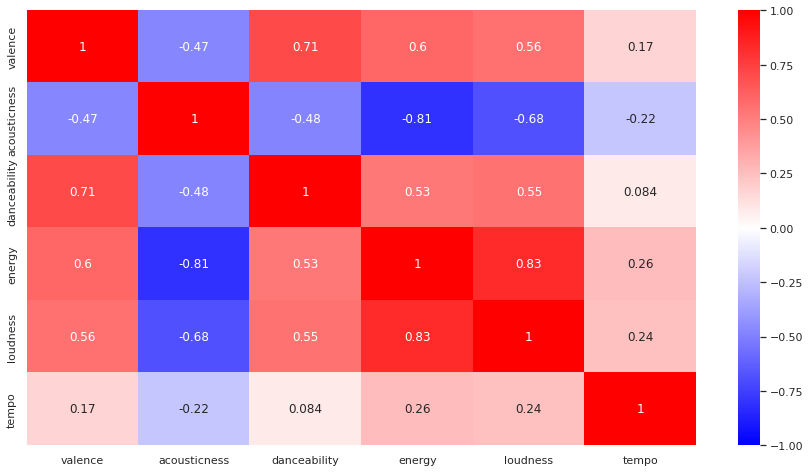

In [2]:
# feature별 상관분석(장르랑 감독 빼야됨 -> 범주형이므로 ..)
corr_feature = norm_value[['valence',	'acousticness',	'danceability',	'energy',	'loudness',	'tempo']]
cor = pd.DataFrame(corr_feature).corr()
# 상관분석 -> heatmap
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cor, annot=True, cmap='bwr', vmin=-1.0, vmax=1.0)  # cmap='Blues', 

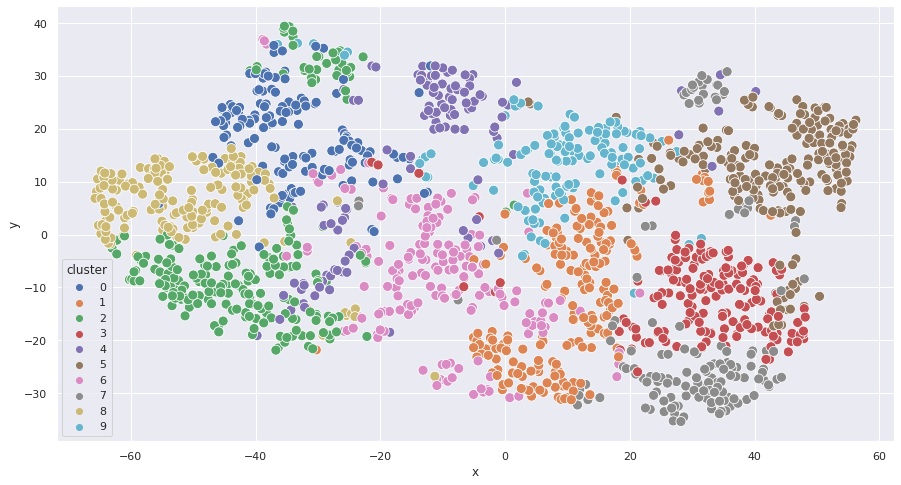

In [3]:
# t-SNE로 차원 축소하여 클러스터링 잘되었는지 확인
x_embedded = TSNE(n_components=2).fit_transform(norm_value)
x_embedded
t_sne = pd.DataFrame(data=x_embedded, columns=['x', 'y'])
new_tsne = pd.concat([t_sne, movieOst['cluster']], axis=1)
sns.scatterplot(x='x', 
                y='y', 
                hue='cluster', # different colors by group
                s=100, # marker size
                palette='deep',
                data=new_tsne)
plt.show()

In [6]:
clusterdata = pd.read_csv('/content/clusterdata.csv')

# 검색할 영화 제목 입력
title = input('영화 제목을 입력하세요').strip()
title_movie = clusterdata[clusterdata['movie_name'] == title]

# 영화의 Title OST가 여러개라면 OST 정보 추가 입력후 영화 id 가져오기, 1개라면 바로 영화 id 가져오기
if len(title_movie['ost_name']) != 1:
  show_feature = title_movie[title_movie['movie_name'] == title]
  show_feature = show_feature[['movie_name', 'ost_name']]
  print(show_feature)
  ost_in = input('원하는 ost를 입력하세요').strip()
  feature_list = title_movie[title_movie['ost_name'] == ost_in]
  feature_list = feature_list.head(1)
  title_idx = feature_list['id']
  title_id = feature_list.iloc[0, 0]
else:
  feature_list = title_movie.head(1)
  title_idx = feature_list['id']
  title_id = feature_list.iloc[0, 0]

# 검색한 영화 OST의 Feature 가져오기
feature_list = feature_list[['valence','acousticness','danceability','energy','loudness','tempo','genre','director']]

# 입력받은 영화가 속해있는 cluster 찾기
cluster = clusterdata[clusterdata['id'] == title_id].values[0][-1]
clus_data = clusterdata[clusterdata['cluster'] == cluster]

# 검색한 영화와 동일한 클러스터의 다른 영화 사이의 유클리디안 거리 구하기
dist_list = []
for i, row in clus_data.drop(title_idx).iterrows():
  row_feature_list = clus_data.loc[i, ['valence','acousticness','danceability','energy','loudness','tempo','genre','director']]
  dist = distance.euclidean(feature_list, row_feature_list)
  dist_list.append((row['id'], dist))
  # 유클리디안 거리가 짧은 순으로 정렬
  dist_list = sorted(dist_list, key=lambda x: x[1])

# 유클리디안 거리가 짧은 순서대로 id 가져오기
num_mv_list = []
for num in range(0, len(dist_list)):
  num_mv_list.append(dist_list[num][0])
re_mov = clusterdata.iloc[num_mv_list]
re_mov.reset_index(drop=True, inplace=True)

# 유클리디안 거리가 컬럼 추가 및 가져오기
re_mov['eucld'] = -1
for num_eu in range(0, len(re_mov['eucld'])):
  re_mov['eucld'][num_eu] = 100*dist_list[num_eu][1]/dist_list[-1][1]

# 영화 중복 제거
re_mov.drop_duplicates(['movie_name'], keep = 'first', inplace = True)  
del_ind = re_mov[re_mov['movie_name'].str.contains(title)].index
# 검색한 영화 제거
re_mov.drop(del_ind, inplace = True)
re_mov.reset_index(drop=True, inplace=True)
re_mov = re_mov[['id', 'movie_name' ,'ost_name', 'cluster', 'eucld']]
re_mov = re_mov.iloc[:10]

영화 제목을 입력하세요Zootopia
    movie_name          ost_name
375   Zootopia    Try Everything
376   Zootopia  Jumbo Pop Hustle
377   Zootopia    Walk and Stalk
378   Zootopia   Ticket to Write
원하는 ost를 입력하세요Try Everything


In [7]:
re_mov.head(10)  # 영화는 Zootopia 검색하고 ost는 Try Everything 선택

id                       movie_name  \
0   747                        Moneyball   
1    32                          Encanto   
2    40          Space Jam: A New Legacy   
3  1263  Charlie's Angels: Full Throttle   
4  1071                    Casino Royale   
5  1076                   Curious George   
6   524         The Amazing Spider-Man 2   
7   660                            Brave   
8  1379                          Bandits   
9  1075                            Crank   

                                            ost_name  cluster  eucld  
0                                           The Show        3      5  
1                                The Family Madrigal        3      8  
2  Just For Me (feat. SZA) (Space Jam: A New Legacy)        3      8  
3                                     Feel Good Time        3      9  
4  You Know My Name (From "Casino Royale" Soundtr...        3     10  
5                                        Upside Down        3     11  
6  It's On Again (From The Amazing Spider-Man 2 S...        3     11  
7            Touch The Sky (From "Brave"/Soundtrack)        3     11  
8                         Total Eclipse Of The Heart        3     13  
9                                      Turn Me Loose        3     15

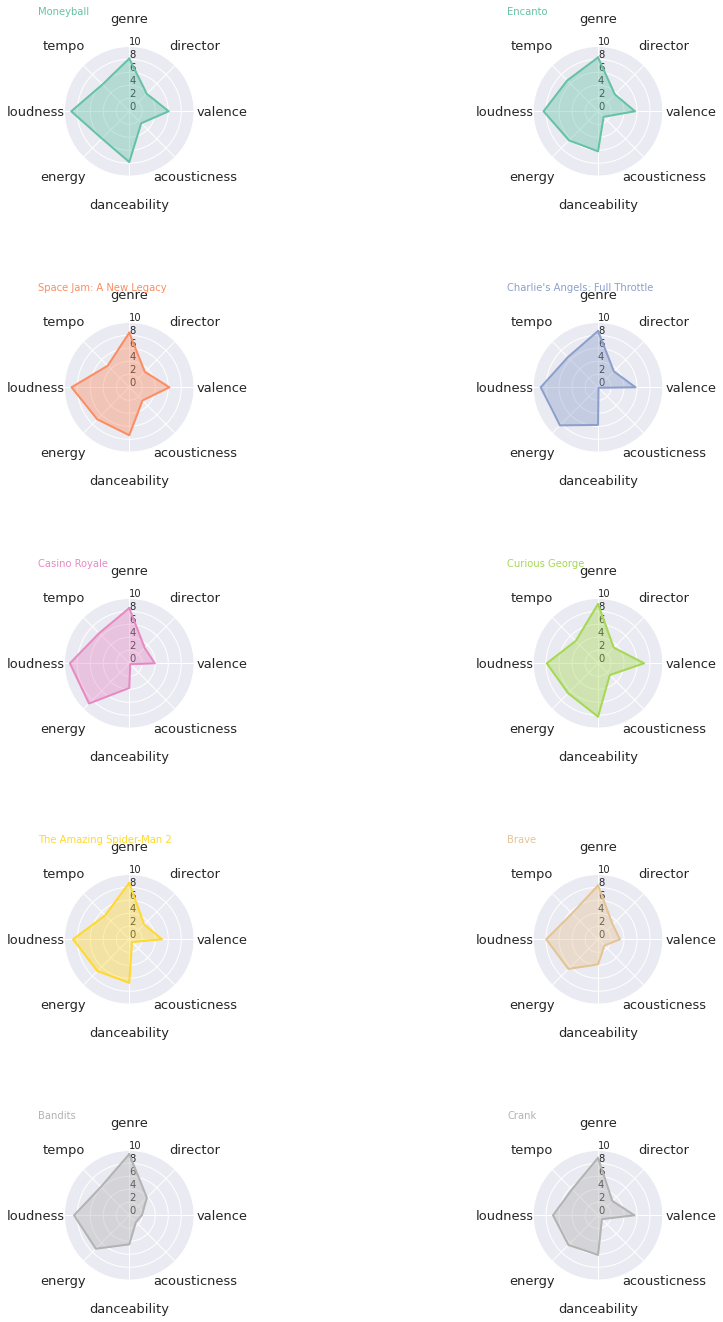

In [8]:
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# 차트 그리기용 데이터 프레임 선언
re_mov_gr = pd.DataFrame()

# 위의 re_mov(추천 받은 영화 10개)에서 id를 가져오고 iloc로 정규화된 데이터를 가져와 데이터 프레임에 추가 (정규화 되지 않은 데이터로 그리면 모양이 이상하게 나옴)
for i in range(len(re_mov['id'])):
  re_mov_gr = pd.concat([re_mov_gr, norm_value.iloc[re_mov['id'][i]]], axis=1)

# 정규화된 데이터는 0~1이므로 10곱하기 - 더 잘보이게 하려고 + 가져온 코드가 0~10까지 나오도록 그려서 / 인덱스 초기화
re_mov_gr = re_mov_gr.T.mul(10)
re_mov_gr.reset_index(drop=True, inplace=True)

# 영화이름 추가해주기 (norm_value 데이터 프레임에는 영화이름 컬럼 없음)
re_mov_gr = pd.concat([re_mov['movie_name'], re_mov_gr], axis = 1)

# 라벨 선언
labels = re_mov_gr.columns[1:]
num_labels = len(labels)

angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] # 각 등분점, 라벨이 8개니까 2pi(360도)/8를 8번 리스트에 담아주기
angles += angles[:1] # 시작점으로 다시 돌아와야하므로 시작점 추가

# 색넣는거 자세히는 모름
my_palette = plt.cm.get_cmap("Set2", len(re_mov_gr.index))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
 
for i, row in re_mov_gr.iterrows():
    color = my_palette(i)
    data = re_mov_gr.iloc[i].drop('movie_name').tolist()  # 영화제목 제외한 feature들 가져오기
    data += data[:1] # 시작점으로 다시 돌아와야하므로 시작점 추가
    
    # 여러개 그래프 한번에 그리기 위한 ax
    ax = plt.subplot(5,2,i+1, polar=True)
    ax.set_theta_offset(pi / 2) # 시작점
    ax.set_theta_direction(-1) # 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) # x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) # x축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) # y축 각도 설정(degree 단위)
    plt.yticks([0,2,4,6,8,10],['0','2','4','6','8','10'], fontsize=10) # y축 눈금 설정
    plt.ylim(0,10)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') # 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) # 도형 안쪽에 색을 채워준다.
    
    plt.title(row.movie_name, size=10, color=color,x=-0.2, y=1.2, ha='left') # 제목은 영화이름으로 함
 
plt.tight_layout(pad=5) # subplot간 패딩 조절
plt.show()

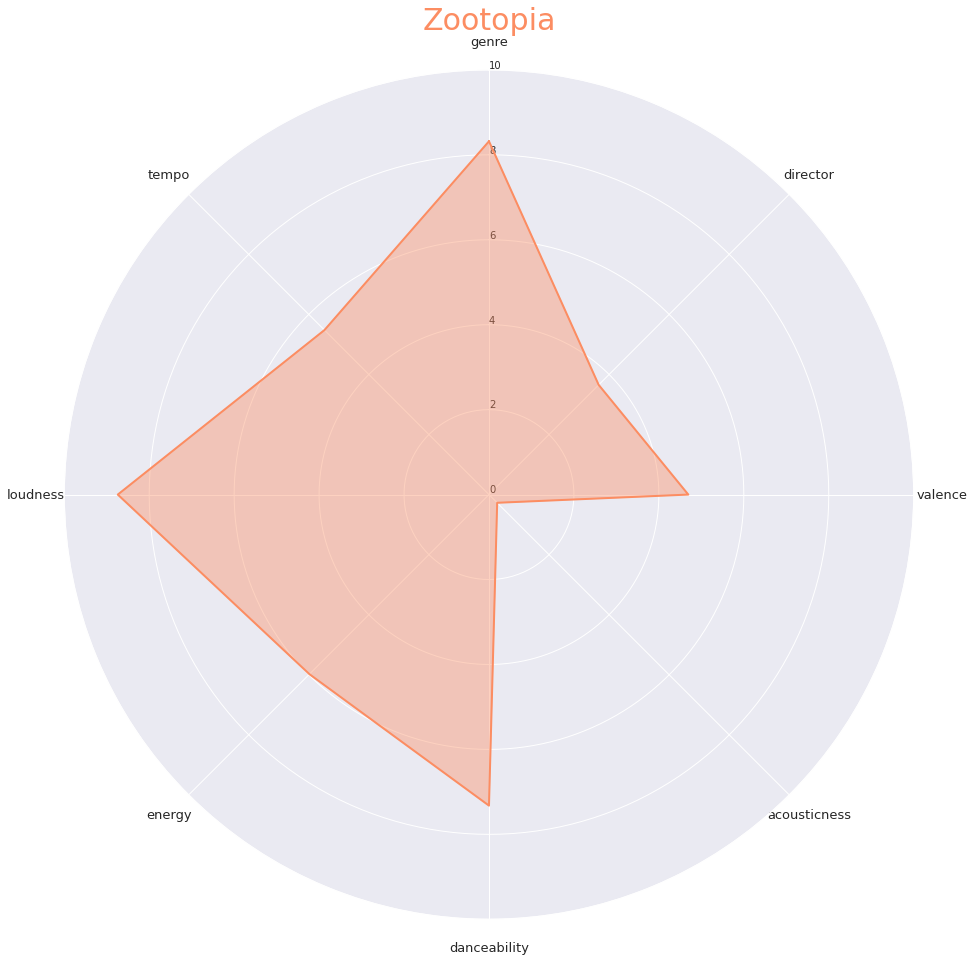

In [9]:
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# 위에서 검색했던 영화만 레이더 차트 그리기
pick_mv_gr = norm_value.iloc[title_id]
pick_mv_gr = pick_mv_gr.mul(10)

labels = norm_value.columns[:]
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] # 각 등분점
angles += angles[:1] # 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("Set2", len(pick_mv_gr.index))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
 
color = my_palette(1)
data = pick_mv_gr.tolist()
data += data[:1]

ax = plt.subplot(1,1,1, polar=True)
ax.set_theta_offset(pi / 2) # 시작점
ax.set_theta_direction(-1) # 그려지는 방향 시계방향

plt.xticks(angles[:-1], labels, fontsize=13) # x축 눈금 라벨
ax.tick_params(axis='x', which='major', pad=15) # x축과 눈금 사이에 여백을 준다.

ax.set_rlabel_position(0) # y축 각도 설정(degree 단위)
plt.yticks([0,2,4,6,8,10],['0','2','4','6','8','10'], fontsize=10) # y축 눈금 설정
plt.ylim(0,10)

ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') # 레이더 차트 출력
ax.fill(angles, data, color=color, alpha=0.4) # 도형 안쪽에 색을 채워준다.

plt.title(title, size=30, color=color,x=0.5, y=1, ha='center') # 타이틀은 캐릭터 클래스로 한다.
 
plt.tight_layout(pad=5) # subplot간 패딩 조절
plt.show()